In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

/kaggle/input/ecommerce-events-history-in-electronics-store/events.csv


In this project, we are going to dive through the datasets of ecommerce user event history in electronics field specifically of a large online shop in order to improve budget relocation for sales, product, and marketing. With over 800k instances collected by Open CDP project, we will perform sale trend, funnel, and product analytics with time dimension of 5 months (Oct 2020-Feb 2021). 

# Load Dataframe

In [2]:
df = pd.read_csv('/kaggle/input/ecommerce-events-history-in-electronics-store/events.csv')
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


# Quality Check
Our quality check section will focus on following aspects:
* null values
* data types
* duplicates
* outliers - not for this proj
* value ranges
* cross-column dependency - not for this proj
* inconsistent data entry - not for this proj

## Check missing values

In [3]:
df.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    236219
brand            212364
price                 0
user_id               0
user_session        165
dtype: int64

Based on the metrics, the column `category_code` and `brand` has the most null values. There are also a small amount of null values in `user_session`. 

For `category_code`, we could try fill the null values based on other existing category id and code first. If this approach doesn't solve the problem, then we only will be able to do the category analysis based on instances with non-null `category-code`.

As for `brand`, there's no other information related to the attribute, which means that in order to complete analysis with regards to brand, we will only be able to utilize non-null `brand` rows.

`user_session` seems to be an abstract feature which we can temporarily ignore. 

In [4]:
# create dictionary
notnull_code = df[pd.notna(df['category_code'])]
category_dic = notnull_code.set_index('category_id')['category_code'].to_dict()

# fill null with dictionary
df['category_code'] = df.category_code.fillna(df.category_id.map(category_dic))

# check result
df.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    236219
brand            212364
price                 0
user_id               0
user_session        165
dtype: int64

There's no change in the result, which means that the null values can't be solved with the method. We can only remove null in `category_code` for further analysis now.

In [5]:
# remove instance with null category code
df.dropna(subset = ['category_code'], inplace = True)

# transform category_code to category
df['category'] = df['category_code'].str.split('.').str[0]

## Check data types

In [6]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
category          object
dtype: object

In [7]:
# turn to datetime format & remove time zone
df['event_time'] = pd.to_datetime(df['event_time'])

In [8]:
# add year-month attribute
#df['event_month'] = df['event_time'].dt.to_period('M')
df['event_month'] = df['event_time'].dt.strftime('%Y-%m')

## Check duplicates

In [9]:
# identify duplicates
df[df.duplicated()]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,event_month
512,2020-09-24 13:51:07+00:00,view,387956,2144415922427789416,computers.components.videocards,asus,104.21,1515915625519429853,PZu2caZ5EN,computers,2020-09
975,2020-09-24 15:48:55+00:00,view,874667,2144415922738167921,computers.components.cdrw,asus,23.48,1515915625519457150,8wvs0vbHtv,computers,2020-09
4828,2020-09-25 13:15:09+00:00,view,453469,2144415924222951574,auto.accessories.parktronic,NaN,69.84,1515915625519725870,9ofICyh8Eo,auto,2020-09
6144,2020-09-25 19:31:42+00:00,view,1010933,2144415921932861531,electronics.telephone,NaN,10.79,1515915625492539666,dfyeBb7YCt,electronics,2020-09
10976,2020-09-27 08:44:40+00:00,view,586461,2144415927284793573,computers.components.tv_tuner,tesler,20.16,1515915625520181957,GpuNabv3Ht,computers,2020-09
...,...,...,...,...,...,...,...,...,...,...,...
876838,2021-02-27 11:04:13+00:00,view,1769608,2144415925665792187,appliances.kitchen.meat_grinder,polaris,47.84,1515915625610368365,QgOJiEfwZS,appliances,2021-02
877116,2021-02-27 12:02:26+00:00,view,3804563,2144415926966026460,computers.components.cpu,intel,97.35,1515915625551553663,R97Nw0H5Be,computers,2021-02
878751,2021-02-27 17:56:05+00:00,view,1571204,2144415924491387038,computers.components.motherboard,asus,146.40,1515915625610505518,EUqy2lyCvY,computers,2021-02
879545,2021-02-27 20:54:20+00:00,view,1027953,2144415923837075596,electronics.audio.acoustic,jbl,332.87,1515915625529755153,3mD3HIQ017,electronics,2021-02


In [10]:
# drop duplicates
df = df.drop_duplicates()

## Check value ranges
> By checking if there's value other than `view`, `cart`, `purchase`, we can ensure the value rages of the `event_type` feature.

In [11]:
# identify other event types
funnel_steps = ['view', 'cart', 'purchase']
df[~df['event_type'].isin(funnel_steps)]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,event_month


# Exploratory Data Analysis
## Monthly sales trend by category

In [12]:
# build sales table
sales = df[df['event_type']=='purchase'].groupby(['event_month', 'category'])['price'].agg(['sum', 'count']).reset_index()
sales = sales[sales['event_month']!='2020-09']
sales.rename(columns={'event_month': 'month',
                     'sum': 'total_sales',
                     'count': 'total_orders'}, inplace=True)
sales['aov'] = sales['total_sales']/sales['total_orders']

In [13]:
# check applicability
sales.groupby('category').count()

,month,total_sales,total_orders,aov
category,,,,
accessories,5,5,5,5
appliances,5,5,5,5
auto,5,5,5,5
computers,5,5,5,5
construction,5,5,5,5
country_yard,5,5,5,5
electronics,5,5,5,5
furniture,5,5,5,5
jewelry,1,1,1,1


> We would like to see changes in total sales per category over time, which makes it important to only include categories with all sales over the 5 months. Therefore, we'll only involve `accessories`, `appliances`, `auto`, `computers`, `construction`, `country_yard`, `electronics`, `furniture`, and `stationary` in our visualization.

> Among these categories, we only care about electronics related ones, which eliminates our target to `accessories`, `appliances`, `computers`, and `electronics`.

In [14]:
# select usable instances
categories = ['accessories', 'appliances', 'computers', 'electronics']
sales = sales[sales['category'].isin(categories)]

# integrate data type
sales.loc[:, 'month'] = sales['month'].astype(str)

In [15]:
# create growth rate metrics
sales.loc[:, 'sales_growth_rate'] = sales.groupby('category')['total_sales'].pct_change().round(2)
sales.loc[:, 'aov_growth_rate'] = sales.groupby('category')['aov'].pct_change().round(2)
sales.loc[:, 'order_growth_rate'] = sales.groupby('category')['total_orders'].pct_change().round(2)
sales.fillna(0, inplace=True)

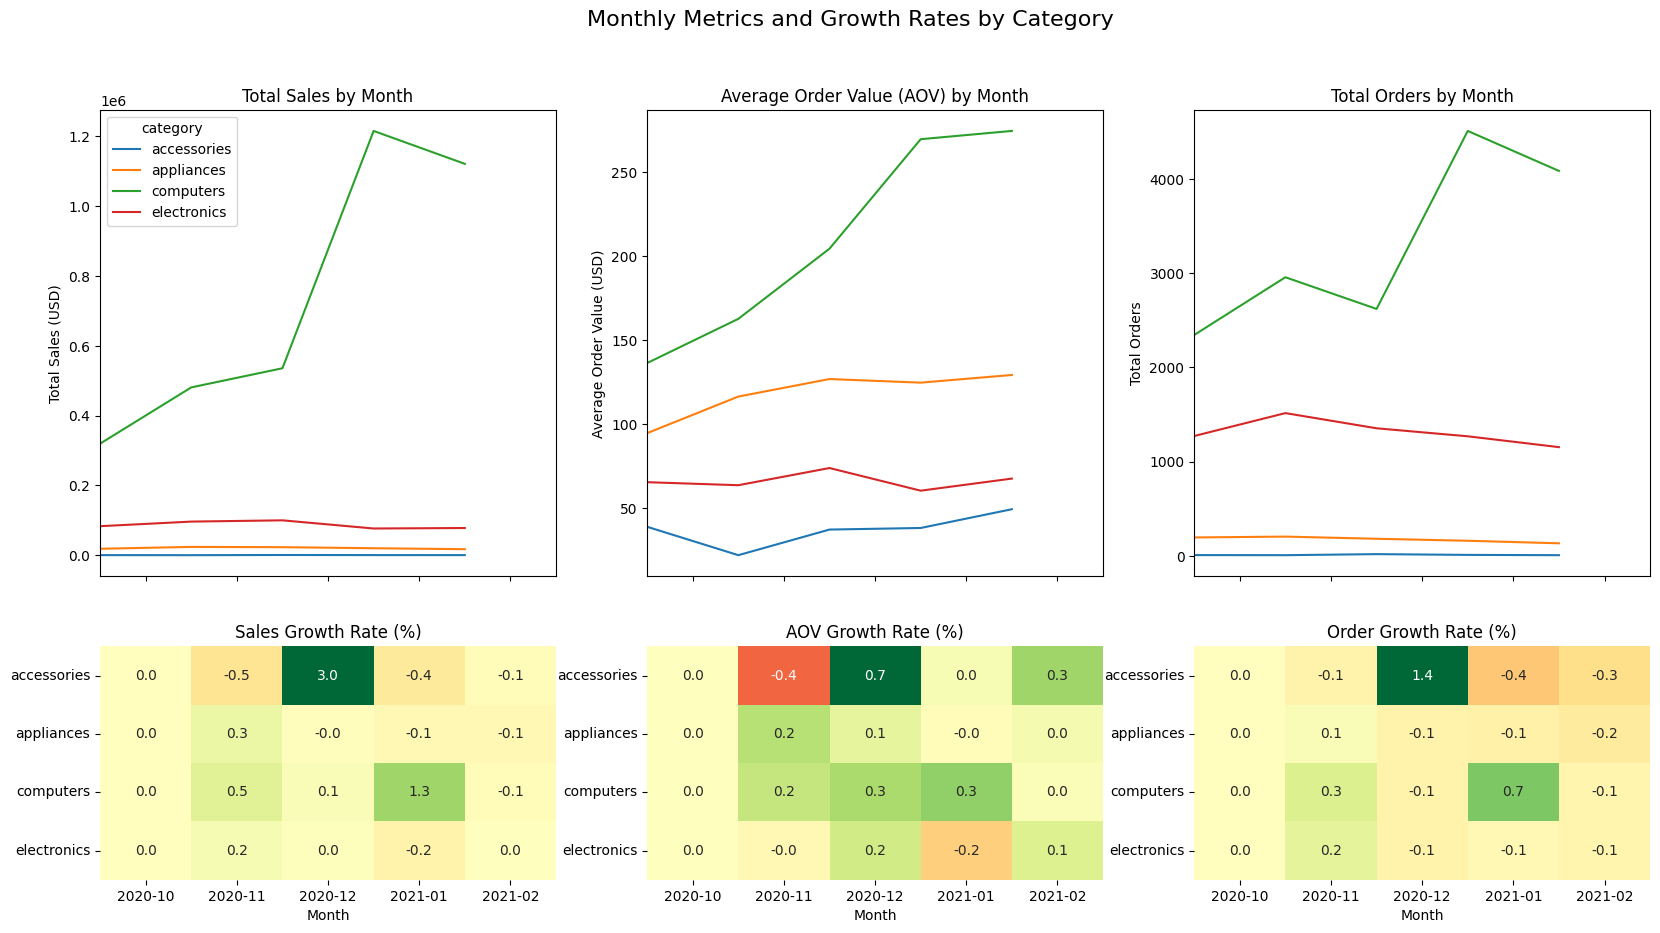

In [16]:
# figure with a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex='col', gridspec_kw={'height_ratios': [2, 1]})

# define color
colors = plt.cm.tab10(np.arange(len(categories))) 

# metrics to plot
metrics = ['total_sales', 'aov', 'total_orders']
titles = ['Total Sales by Month', 'Average Order Value (AOV) by Month', 'Total Orders by Month']
y_labels = ['Total Sales (USD)', 'Average Order Value (USD)', 'Total Orders']
growth_metrics = ['sales_growth_rate', 'aov_growth_rate', 'order_growth_rate']
growth_titles = ['Sales Growth Rate (%)', 'AOV Growth Rate (%)', 'Order Growth Rate (%)']

# line charts for each metric
for i, (metric, title, y_label) in enumerate(zip(metrics, titles, y_labels)):
    
    axes[0, i].set_title(title)
    sns.lineplot(data=sales, x='month', y=metric, ax=axes[0, i], hue='category', legend=(i==0))
    axes[0, i].set_ylabel(y_label)
    
# heatmap for growth metric
for i, (growth_metric, growth_title) in enumerate(zip(growth_metrics, growth_titles)):
    growth_data = sales.pivot_table(index='category', columns='month', values=growth_metric)
    sns.heatmap(growth_data, cmap='RdYlGn', ax=axes[1, i], cbar=False, annot=True, fmt=".1f", center=0)
    axes[1, i].set_title(growth_title)
    axes[1, i].set_xlabel('Month')
    axes[1, i].set_ylabel('')

plt.suptitle('Monthly Metrics and Growth Rates by Category', fontsize=16)
plt.savefig('MonthlyMetrics.png')
plt.show()

## Funnel analysis
We'll explore funnel through the following perspectives:
* session duration
* user event history
### Session duration

In [17]:
# mark session id
df = df.sort_values(['user_id', 'event_time'])
df['session'] = (
    df['event_time'] - df.groupby('user_id')['event_time'].shift()
).dt.seconds > 1800
df['session'] = df['session'].cumsum()

# find session duration
session_lengths = (
    df.groupby('session')['event_time'].agg(['min', 'max']).reset_index()
)
session_lengths['duration'] = (
    session_lengths['max'] - session_lengths['min']
).dt.seconds

<Axes: xlabel='duration', ylabel='Count'>

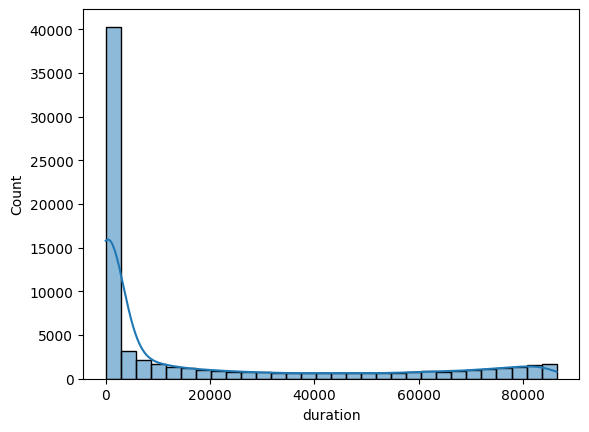

In [18]:
sns.histplot(data = session_lengths, x = 'duration', bins = 30, kde = True)

> **TODO: metrics with table - percentage of session duration within xxx**

### Event history

<Axes: xlabel='event_type', ylabel='user_id'>

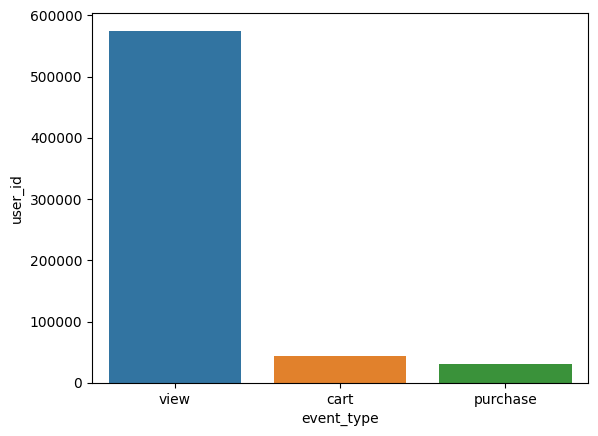

In [19]:
# event history count
event_count = df.groupby('event_type')[['user_id']].count().reset_index()
event_count.sort_values('user_id', ascending = False, inplace = True)
sns.barplot(data = event_count, x = 'event_type', y = 'user_id')

> **TODO: conversion rate of each stage, total sales by month, total aov by month**

### Monthly view distribution by category

> **TODO: area chart for different category's monthly view?**

## Brand performance

In [20]:
# add product feature
df['product'] = df['category_code'].str.split('.').str[-1]

In [21]:
df.groupby('user_session')['event_time'].agg(['min', 'max'])

,min,max
user_session,,
000c34fa-991f-442a-8e07-8c472269bec6,2020-09-30 17:52:02+00:00,2020-09-30 17:52:02+00:00
001HttdHUk,2021-01-09 23:35:49+00:00,2021-01-09 23:35:49+00:00
001P7lK0Pt,2020-11-06 01:25:30+00:00,2020-11-06 01:25:43+00:00
001RxUtFJa,2020-12-29 04:50:33+00:00,2020-12-29 04:50:33+00:00
002DmERG1w,2020-09-26 18:59:06+00:00,2020-09-26 18:59:06+00:00
...,...,...
zzx67A1jBp,2021-02-16 10:57:16+00:00,2021-02-16 10:59:41+00:00
zzxnA0nWEY,2020-11-17 11:34:14+00:00,2020-11-17 11:34:14+00:00
zzy0qXtxYX,2020-11-08 17:08:01+00:00,2020-11-08 17:08:01+00:00


Export data frame for further Excel analysis.

In [22]:
#df.to_csv('output.csv')

## Repeat Purchases

In [23]:
# times of purchases per customer
purchase = df[(df['event_type']=='purchase') & (df['category'].isin(categories))]
purchase = purchase.sort_values([
    'event_time', 'user_id'
]).reset_index().drop('index', axis=1)
purchase['purchase'] = purchase.groupby(['user_id']).cumcount()+1

In [32]:
# export data for excel analysis
# purchase.to_csv('purchase.csv')
purchase['event_date'] = purchase['event_time'].dt.date

In [25]:
# mean times of purchases per customer
np.mean(purchase['purchase']-1)

1.1889584519066592

In [26]:
purchase_count = purchase.groupby([
    'category', 'user_id'
])['event_month'].count().reset_index()
purchase_count.rename(columns={'event_month': 'purchase_count'}, inplace=True)

In [27]:
purchase_count.groupby('category')['purchase_count'].mean().reset_index()

,category,purchase_count
0,accessories,1.696970
1,appliances,1.631769
2,computers,1.790300
3,electronics,1.634388


## Session Duration

In [28]:
df[df['category']=='computers'].groupby(['user_id', 'user_session', 'brand', 'event_type'])['product_id'].count().reset_index()

,user_id,user_session,brand,event_type,product_id
0,1515915625353230683,YSbSzDlwcX,canon,view,1
1,1515915625353230922,PeKjQrbkxf,msi,view,1
2,1515915625353286099,1O3MiQcUAZ,zyxel,view,1
3,1515915625353286099,7ZE3RhNYE6,tp-link,cart,1
4,1515915625353286099,7ZE3RhNYE6,tp-link,view,1
...,...,...,...,...,...
181669,1515915625611022570,GSzml30F1S,gigabyte,view,1
181670,1515915625611022685,hQmazVfmpb,dell,view,1
181671,1515915625611022696,UltuQEPZUB,amd,view,1
181672,1515915625611023376,GheawAs525,dockcase,view,1


In [33]:
purchase.to_csv('purchase.csv')